# CCD spectrometer
* ## Background
* ## Sulfur - Temperature measurement

All counts are transformed to rates. 
Background is then subtracted. 

Errors are taken to be the statistical ones: $s_N = \frac{\sqrt{N}}{\sqrt{n}}$, where N is the number of counts and n the number of measurements that have been measured over.

The xlim for plotting is set globally.

In [1]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [2]:
import re
from scipy.constants import c,h,eV, pi
hceV = h * c  /eV
find_number = lambda string: re.search("-?\\d+",string).group(0)

from smooth import savitzky_golay
import uncertainties as uc
import uncertainties.unumpy as un

plt.close("all")
show_fig = True
save_fig = False # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)  # in inches; width corresponds to \textwidth in latex document (golden ratio)
        fig_dir = "../figures/"
        npy_dir = "./npy/"
        
xlim_global = (420, 620)
colors = ['b', 'r', 'g', 'darkmagenta', 'firebrick', 'cyan', 'orange', 'magenta', 'darkgoldenrod']

In [9]:
def breit_wigner(x, x0, gamma, amplitude, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    return amplitude / ((pi*gamma) * (1 + ((x - x0) / gamma)**2)) + offset
   
def bw_fit(x, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = un.nominal_values(y[mask])
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = breit_wigner(x_fit, *coeff)
    else:
        fit_peak = breit_wigner(x_fit, *p0)
        c = p0
    
    return x_fit, fit_peak, c

In [10]:
def uc_str(c):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max 4 error digits
    as floats with max 3 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < 4): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

In [11]:
def t_avg(filename):
    """
    Get integration time and number of measurements
    """
    f = open("data/" + filename + ".txt", encoding='cp1252')
    lines = f.readlines()
    f.close()
    t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
    avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from
    return t, avg

## Background

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


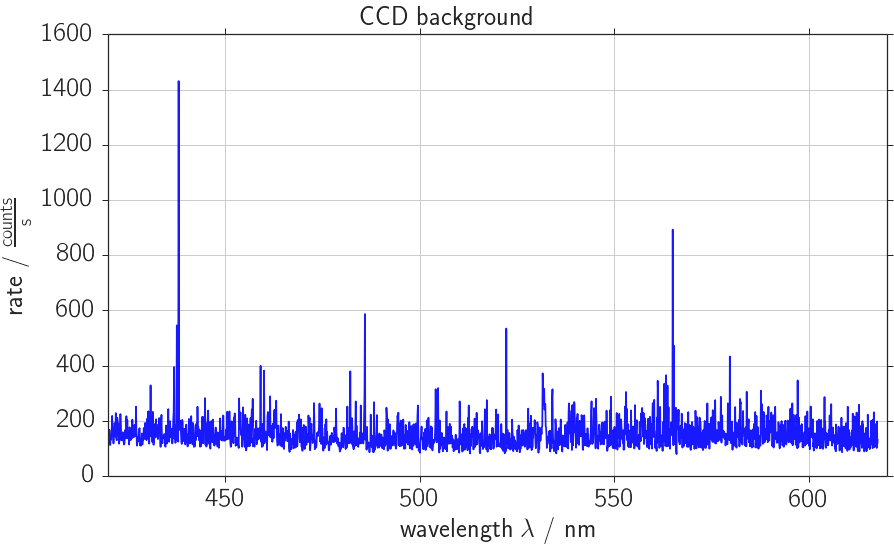

In [13]:
#### Background ####
filename = "ccd_bg_30_10"

# Get integration time and number of measurements
f = open("data/" + filename + ".txt", encoding='cp1252')
lines = f.readlines()
f.close()
t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from

# Data
x = np.load("npy/"+filename+"_lamb.npy")
y = np.load("npy/"+filename+"_count.npy")
y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))

rate_bg = y / t
rate_bg_e = y_e / t

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD background')
ax.plot(x, rate_bg, "-", alpha = 0.9, c=colors[0])
ax.set_xlim(xlim_global)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
#ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_background"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

## Sulfur
* Get data
* Fit Stokes and Anti-Stokes peak for each laser intensity.
* Notch filter is plotted in order to see its influence.

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


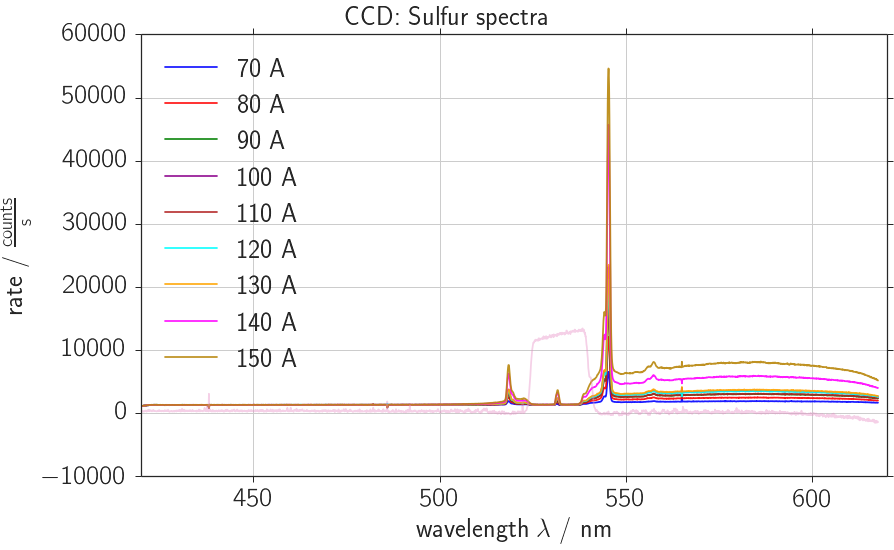

In [14]:
As = []

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: Sulfur spectra')
    
I_laser_all = [70, 80, 90, 100, 110, 120, 130, 140, 150]
#I_laser_all = [130]

for i, I_laser in enumerate(I_laser_all):
    filename = "ccd_s_" + str(I_laser).zfill(3)
    t, avg = t_avg(filename)
     
    # Data
    x = np.load("npy/"+filename+"_lamb.npy")
    y = np.load("npy/"+filename+"_count.npy")
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))
    y = y / t - rate_bg
    y_e = y_e / t - rate_bg_e
    ax.plot(x, y, "-", alpha = 0.9, c=colors[i], label=str(I_laser) + ' A')
    
    # Peak fit
    # Stokes peak
    x_range1 = [545, 549]   # lower and upper bound
    p0 = np.array([545.5, 0.2, 20000, 3500])
    x_fit1, fit_peak1, c1 = bw_fit(x, y_e, x_range1, p0, fit=True)
    #ax.plot(x_fit1, fit_peak1, "--", c=colors[i], label='Stokes')

    # Anti-Stokes peak
    x_range2 = [510, 519]   # lower and upper bound
    p0 = np.array([518, 0.2, 5000, 200])
    x_fit2, fit_peak2, c2 = bw_fit(x, y_e, x_range2, p0, fit=True)
    #ax.plot(x_fit2, fit_peak2, "--", c=colors[i], label='Anti-Stokes')

    # Collect intensities
    As.append([c_i[2] for c_i in [c1, c2]])

    
# display notch filter in order to identify its effects
notch = np.load("npy/ccd_notch.npy")
ax.plot(x, notch * 0.3, "-", alpha = 0.4)

ax.set_xlim(xlim_global)
#ax.set_xlim(540, 560)
#ax.set_xlim(510, 530)
#ax.set_ylim(0, 10000)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "ccd_sulfur_spectra"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

The intensity is supposed to follow the relationship

$\frac{I_{AS}}{I_{S}} \propto \mathrm{e}^{-\frac{h \Delta \nu}{k_B T}}$

and should thus be constant for all intensities (ignoring warming due to the laser...). We take the mean value of all measured ones.

/usr/lib/python3/dist-packages/matplotlib/axes.py:4749: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


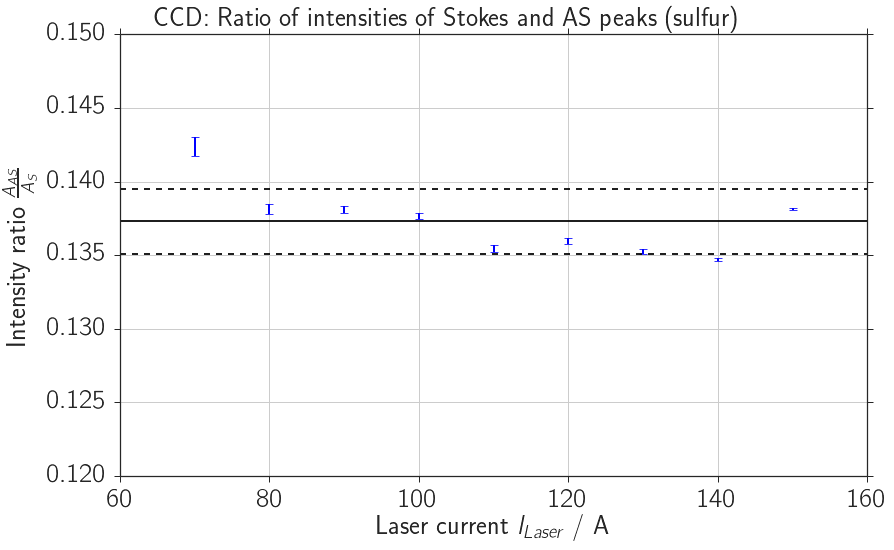

In [15]:
A_I = np.array(As).T
A_ratio = A_I[1] / A_I[0]
y = un.nominal_values(A_ratio)
sy = un.std_devs(A_ratio)

mean_ratio = np.mean(y)
std_ratio = np.std(y)

fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: Ratio of intensities of Stokes and AS peaks (sulfur)')

ax.errorbar(I_laser_all, y, xerr=None, yerr=sy, fmt=',', c=colors[0], elinewidth=2.0, capsize=4.2, capthick=0.8)
ax.plot([60, 160], [mean_ratio]*2, '-', c='k')
ax.plot([60, 160], [mean_ratio - std_ratio]*2, '--', c='k')
ax.plot([60, 160], [mean_ratio + std_ratio]*2, '--', c='k')

ax.set_xlim(60, 160)
ax.set_ylim(0.12, 0.15)
ax.set_xlabel('Laser current $I_{Laser}$ / A')
ax.set_ylabel('Intensity ratio $\\frac{A_{AS}}{A_{S}}$')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "ccd_temp_rate"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")


In [72]:
np.std(y)

0.002218893385081988

In [61]:
I_laser

150